# Query-by-committee

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
from tqdm.notebook import tqdm, trange
from collections import namedtuple
from modAL.models import Committee, ActiveLearner
from modAL.disagreement import vote_entropy_sampling, consensus_entropy_sampling, max_disagreement_sampling
from skorch import NeuralNetClassifier
from torchvision import datasets
from joblib import Parallel, delayed
from modAL.models.base import BaseCommittee
from modAL.utils.data import modALinput

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

sns.set_theme(style="darkgrid")

ResultsRecord = namedtuple('ResultsRecord', ['estimator', 'query_id', 'score'])

In [2]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [3]:
def create_learner(X_training, y_training, max_epochs=10, module__num_classes=3):
    net = NeuralNetClassifier(
        SimpleCNN,
        max_epochs=max_epochs,
        lr=0.001,
        optimizer=torch.optim.Adam,
        criterion=nn.CrossEntropyLoss,
        device="cuda" if torch.cuda.is_available() else "cpu",
        train_split=None,
        verbose=0,
        iterator_train__shuffle=True,
        module__num_classes=module__num_classes,
        batch_size=32,
    )
    return ActiveLearner(
        estimator=net,
        query_strategy=vote_entropy_sampling,
        X_training=X_training,
        y_training=y_training,
    )

In [4]:
def load_filtered_CIFAR(
    selected_labels, num_train_per_class=200, num_test_per_class=100
):
    train = datasets.CIFAR100(root="./data", train=True, download=True)
    test = datasets.CIFAR100(root="./data", train=False, download=True)

    def filter_data(X, y, n):
        filtered_images = []
        filtered_labels = []

        for i, label in enumerate(selected_labels):
            indices = np.where(y == label)[0][:n]
            filtered_images.append(X[indices])
            filtered_labels.append(np.full(len(indices), i))

        X_filtered = np.concatenate(filtered_images, axis=0).astype(np.float32) / 255.0
        y_filtered = np.concatenate(filtered_labels, axis=0).astype(np.int64)

        # Reshape to (N, C, H, W) format
        X_filtered = X_filtered.transpose(0, 3, 1, 2)

        return X_filtered, y_filtered

    X_train, y_train = filter_data(
        train.data, np.array(train.targets), num_train_per_class
    )
    X_test, y_test = filter_data(test.data, np.array(test.targets), num_test_per_class)

    return X_train, y_train, X_test, y_test

In [5]:
def run_active_learning(
    i,
    method,
    committee_size,
    X_train,
    y_train,
    X_test,
    y_test,
    n_initial=10,
    n_queries=50,
    query_batch_size=1,
):
    method_name, method_func = method
    initial_indices = np.random.choice(len(X_train), n_initial, replace=False)
    X_init, y_init = X_train[initial_indices], y_train[initial_indices]

    committee_members = [create_learner(X_init, y_init) for _ in range(committee_size)]
    committee = Committee(committee_members, method_func)
    # committee.teach(X_init, y_init, only_new=True)

    pool_indices = np.setdiff1d(np.arange(len(X_train)), initial_indices)
    X_pool, y_pool = X_train[pool_indices], y_train[pool_indices]

    history = []
    for idx in (pbar := tqdm(range(n_queries),desc=f'Points {i} with {method_name}')):
        predictions = committee.predict(X_test)
        accuracy = np.mean(predictions == y_test)
        history.append(ResultsRecord(method_name, idx, accuracy))

        pbar.set_description(f"Method: {method_name}, Query {idx+1}, Accuracy: {accuracy:.4f}")

        query_idx, _ = committee.query(X_pool, n_instances=query_batch_size)

        committee.teach(X_pool[query_idx], y_pool[query_idx])

        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx)

    return history

In [6]:
def random_sampling(committee: BaseCommittee, X: modALinput,
                          n_instances: int = 1, random_tie_break=False,
                          **disagreement_measure_kwargs):
    query_idx = np.random.choice(len(X), n_instances)
    return query_idx, np.zeros(n_instances)


In [12]:
# Experiments
selected_labels = [0, 1, 2]
n_classes = len(selected_labels)
n_initials = 30
n_queries = 50
committee_size = 8
n_repeats = 10
query_batch_size = 1
disagreement_methods = {
    "vote_entropy_sampling": vote_entropy_sampling, 
    "consensus_entropy_sampling": consensus_entropy_sampling, 
    "max_disagreement_sampling": max_disagreement_sampling,
    "random_sampling": random_sampling
    }
run_parallel = True

X_train, y_train, X_test, y_test = load_filtered_CIFAR(selected_labels)

In [ ]:
combinations = it.product(range(n_repeats), disagreement_methods.items())
num_samples = n_repeats * len(disagreement_methods)

if run_parallel:
    result = [r for r in tqdm(Parallel(return_as="generator", n_jobs=2)(delayed(run_active_learning)(i, method, committee_size, X_train.copy(), y_train.copy(), X_test.copy(), y_test.copy(), n_queries=n_queries, query_batch_size=query_batch_size)
                    for i, method in combinations), total=num_samples)]
else:   
    results = [run_active_learning(i, method, committee_size, X_train, y_train, X_test, y_test, n_queries=n_queries, query_batch_size=query_batch_size)
           for i, method in tqdm(combinations, total=num_samples)]

committee_results = [r for rs in results for r in rs]

  0%|          | 0/40 [00:00<?, ?it/s]

In [144]:
df_results = pd.DataFrame(committee_results)
df_results.to_csv("data.csv")
df_results["estimator"].unique()

array(['vote_entropy_sampling', 'consensus_entropy_sampling',
       'max_disagreement_sampling', 'random_sampling'], dtype=object)

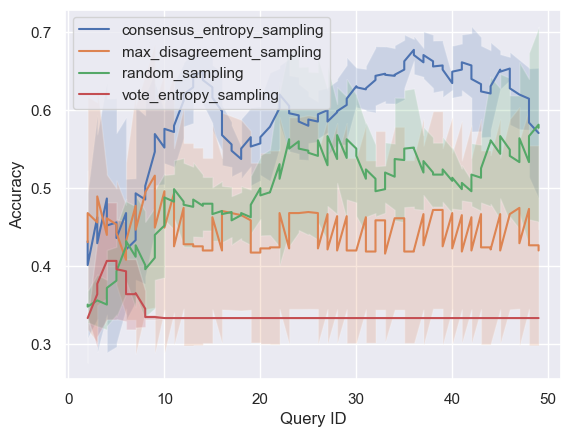

In [145]:
df_results = pd.read_csv("data.csv")
fig, ax = plt.subplots()
for est, grp in df_results.groupby("estimator"):
    grp = grp.sort_values("query_id")
    mean = grp["score"].rolling(5).mean()
    std = grp["score"].rolling(5).std()
    ax.plot(grp["query_id"], mean, label=est)
    ax.fill_between(grp["query_id"], mean - std, mean + std, alpha=0.2)
ax.set_xlabel("Query ID")
ax.set_ylabel("Accuracy")
ax.legend()
plt.show()